In [1]:
%matplotlib inline
import os
import os.path as osp
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting

General setup

In [2]:
project_folder = '/data/shared/ptsdchild'
analysis_folder = osp.join(project_folder, 'analysis', 'resting_state', 'patients_ptsdchild_maps_dim70.gigica')
ml_folder = osp.join(analysis_folder, 'ml_analysis')
between_folder = osp.join(analysis_folder, 'group_comparison', 'between_networks')
svm_weights_folder = osp.join(ml_folder, 'svm_weights_pvals')

figures_folder = osp.join(project_folder, 'code', 'resting_state', 'analysis', 'figures_creation', 'figures')

if not osp.exists(figures_folder):
    os.makedirs(figures_folder)

#### Figure 3: performance for significant network
* Loading data first

In [3]:
alpha = 0.05 
template_file_name = '{}_clf_performance.csv'
df_results = pd.read_csv(osp.join(ml_folder, 'all_results.csv'), index_col=0, header=[0, 1])
id_significant = df_results.index[df_results[('ACC', 'p_FWE')] < alpha]
print(id_significant)
df_perf = pd.read_csv(osp.join(ml_folder, template_file_name.format(id_significant[0])))
label_renamer = {'test_ACC': 'Accuracy', 'test_AUC': 'AUC', 'test_SENS': 'Sensitivity',
                 'test_SPEC': 'Specificity', 'test_PPV': 'PPV', 'test_NPV': 'NPV'}
print('Order: {}'.format(label_renamer.keys()))

all_data = []
all_labels = []
for label in label_renamer.keys():
    all_data = np.concatenate((all_data, df_perf[label].to_numpy()))
    all_labels = np.concatenate((all_labels, [label_renamer[label]] * df_perf.shape[0]))

df_perf_long = pd.DataFrame(data=np.column_stack((all_data, all_labels)), columns=['performance', 'metrics'])
df_perf_long.performance = df_perf_long.performance.astype('float64')
df_perf_long.metrics = df_perf_long.metrics.astype('str')

Index(['ic0024'], dtype='object')
Order: dict_keys(['test_ACC', 'test_AUC', 'test_SENS', 'test_SPEC', 'test_PPV', 'test_NPV'])


* Making the Figure

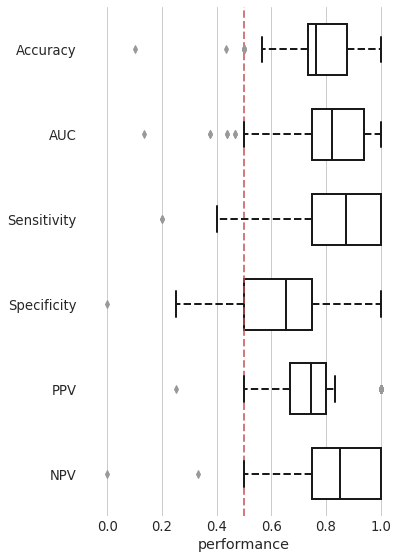

In [201]:
sns.set(style='ticks', font_scale=1.2)
fig, ax = plt.subplots(figsize=(6, 8))
ax.axvline(0.5, 0, 1, lw=2, ls='--', c='r', alpha=0.75, zorder=1)
sns.boxplot(x='performance', y='metrics', data=df_perf_long, ax=ax, showfliers=True, color='w',
            linewidth=2, whiskerprops={'color': 'k', 'ls': '--'}, width=0.6, meanline=True, showmeans=True,
            capprops={'color': 'k'}, boxprops={'edgecolor': 'k'}, 
            medianprops={'lw': 0}, meanprops={'color': 'k', 'ls': '-', 'lw': 2, 'zorder': 3}, zorder=2)
ax.xaxis.grid(True)
ax.set_ylabel('')
ax.set_xlim([-0.1, 1.1])
ax.tick_params(axis='both', which='both', length=0)
sns.despine(trim=False, left=True, bottom=True)
fig.tight_layout()
fig.savefig(osp.join(figures_folder, 'figure3_classification_performance.png'))
fig.savefig(osp.join(figures_folder, 'figure3_classification_performance.pdf'))

#### Figure 1: Between network connectivity
* Loading data

In [141]:
# p_values are stored as 1-p
alpha = 0.95

df_correlations = pd.read_csv(osp.join(between_folder, 'unique_correlation_matrix.csv'), header=None)
print('n_subj: {}; n_connections: {}'.format(*df_correlations.shape))
df_result = pd.read_csv(osp.join(between_folder, 
                                 'palm_responder_vs_nonresponder_30perc_dat_tstat_mcfwep_m1_c2.csv'),
                        header=None)
result = df_result.to_numpy().squeeze()
id_significant = result > alpha
p_max = 1 - result[id_significant][0]
print('n_significant: {}: p_FWE: {}'.format(id_significant.sum(), p_max))
sign_connection = df_correlations.to_numpy()[:, id_significant].squeeze()

df_design = pd.read_csv(osp.join(analysis_folder, 'design', 'design_responder_30perc.csv'))
assert df_design.shape[0] == sign_connection.size
part_labels = np.zeros(sign_connection.size, dtype=object)
part_labels[df_design['responder_30perc_1.0'] == 1] = 'Responder'
part_labels[df_design['responder_30perc_0.0'] == 1] = 'Non-Responder'

df_plotting = pd.DataFrame(data=np.column_stack((sign_connection, part_labels)), columns=['z-score', 'groups'])
df_plotting['z-score'] = df_plotting['z-score'].astype('float64')
df_plotting['groups'] = df_plotting['groups'].astype('str')

n_subj: 40; n_connections: 1128
n_significant: 1: p_FWE: 0.012299999999999978


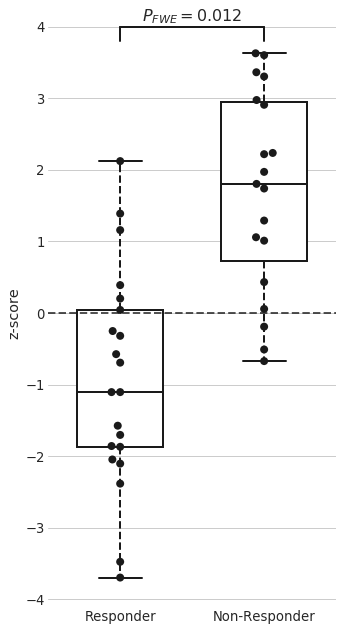

In [174]:
sns.set(style='ticks', font_scale=1.2)
fig, ax = plt.subplots(figsize=(5, 9))
ax.axhline(0, 0, 1, lw=2, ls='--', c='k', alpha=0.75, zorder=1)
sns.boxplot(x='groups', y='z-score', data=df_plotting, ax=ax, showfliers=True, color='w',
            linewidth=2, whiskerprops={'color': 'k', 'ls': '--'}, width=0.6,
            capprops={'color': 'k'}, boxprops={'edgecolor': 'k'}, medianprops={'color': 'k', 'ls': '-', 'lw': 2}, 
            meanprops={'color': 'k', 'ls': '-', 'lw': 2}, zorder=3)
sns.swarmplot(x='groups', y='z-score', data=df_plotting, ax=ax, size=8, color='k')
ax.plot([0, 0], [3.8, 4], '-k', lw=2)
ax.plot([1, 1], [3.8, 4], '-k', lw=2)
ax.plot([0, 1], [4, 4], '-k', lw=2)
ax.annotate(r'$P_{FWE} = $' + str(round(p_max, 3)), (0.5, 4.08), ha='center', fontsize=16)
ax.yaxis.grid(True)
ax.set_xlabel('')
ax.set_ylim([-4.1, 4.1])
ax.tick_params(axis='both', which='both', length=0)
sns.despine(trim=False, left=True, bottom=True)
fig.tight_layout()
fig.savefig(osp.join(figures_folder, 'figure1_part3_between_zscore.png'))
fig.savefig(osp.join(figures_folder, 'figure1_part3_between_zscore.pdf'))

#### Figure 2: SVM weight map
* Loading data
* Making figure

In [207]:
weights_path = osp.join(svm_weights_folder, 'ic0024_totalW_pvals_minuslog10_signed.nii.gz')
plotting.plot_stat_map(weights_path, display_mode='z', symmetric_cbar=True, vmax=5, black_bg=True,
                       cut_coords=[-10, -18, -2, 22, 34, 50, 62, 74], annotate=False, 
                       cmap='cyan_orange', output_file=osp.join(figures_folder, 'figure2_svm_weights_pvals_total.pdf'))

In [208]:
weights_path = osp.join(svm_weights_folder, 'ic0024_meanW_pvals_minuslog10_signed.nii.gz')
plotting.plot_stat_map(weights_path, display_mode='z', symmetric_cbar=True, vmax=5, black_bg=True,
                       cut_coords=[-10, -18, -2, 22, 34, 50, 62, 74], annotate=False, 
                       cmap='cyan_orange', output_file=osp.join(figures_folder, 'figure2_svm_mean_weights_pvals.pdf'))
